<a href="https://colab.research.google.com/github/rosalesparramiguel/ML_ActuarialSciences/blob/main/Modelos_tradicionales_vs_innovadores_para_el_an%C3%A1lisis_de_reservas_para_datos_de_malas_pr%C3%A1cticas_m%C3%A9dicas_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelos tradicionales vs. innovadores para el análisis de reservas para datos de malas prácticas médicas

En este cuaderno de Jupyter, se presenta el código correspondiente a las fases de comprensión, preparación y modelado de datos, siguiendo la metodología CRISP-DM. En particular, se muestra el modelado desde cero para un problema de liderazgo de cadena, y la implementación de un método de regresión. Para la selección del mejor modelo, se utiliza el error cuadrático medio ponderado (MAPE). El código está comentado para facilitar su comprensión, y se incluye la codificación de funciones reutilizables para facilitar la implementación de tareas más complejas.

Procedemos primeramente con la importación de librerías que se utilizaran además de los datos con los que trabajaremos alrededor del notebook

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
CONSULTAS = r"C:\Users\moshe\OneDrive\Documentos\Machine Learning"

In [ ]:
df = pd.read_csv(CONSULTAS+'\\medmal_pos.csv')
df.head(2)

,GRCODE,GRNAME,AccidentYear,DevelopmentYear,DevelopmentLag,IncurLoss_F2,CumPaidLoss_F2,BulkLoss_F2,EarnedPremDIR_F2,EarnedPremCeded_F2,EarnedPremNet_F2,Single,PostedReserve97_F2
0,669,Scpie Indemnity Co,1988,1988,1,121905,2716,97966,129104,-6214,135318,0,344558
1,669,Scpie Indemnity Co,1988,1989,2,112211,24576,64117,129104,-6214,135318,0,344558


**DESCRIPCIÓN DE LA VARIABLE**
* GRCODE NAIC: código de empresa (incluidos grupos de aseguradores y aseguradores individuales)
* GRNAME NAIC: nombre de la empresa (incluidos grupos de aseguradores y aseguradores individuales)
* AccidentYear Año del accidente(1988 a 1997)
* DevelopmentYear: Año de desarrollo (1988 a 1997)
* DevelopmentLag: Año de desarrollo (AY-1987 + DY-1987 - 1)
* IncurLoss_F2: Pérdidas incurridas y gastos asignados informados al final del año
* CumPaidLoss_F2: Pérdidas pagadas acumuladas y gastos asignados al final del año
* BulkLoss_F2: Reservas de Bulk e IBNR sobre pérdidas netas y gastos de defensa y contención de costos reportados al final del año
* EarnedPremDIR_F2: Primas ganadas en el año incurrido: directas y asumidas
* EarnedPremCeded_F2: Primas ganadas en el año incurrido - cedidas
* EarnedPremNet_F2: Primas ganadas en el año en que se produce - netas
* Single:  1 indica una sola entidad, 0 indica una aseguradora grupal
* PostedReserve97_F2: Reservas contabilizadas en el año 1997 tomadas del Anexo de Suscripción e Inversiones - Parte 2A, incluidas las pérdidas netas no pagadas y los gastos de ajuste de pérdidas no pagados

In [ ]:
# 1. Descripción de las variables
variables_descripcion = df.describe(include='all')
variables_info = df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   GRCODE              3400 non-null   int64 
 1   GRNAME              3400 non-null   object
 2   AccidentYear        3400 non-null   int64 
 3   DevelopmentYear     3400 non-null   int64 
 4   DevelopmentLag      3400 non-null   int64 
 5   IncurLoss_F2        3400 non-null   int64 
 6   CumPaidLoss_F2      3400 non-null   int64 
 7   BulkLoss_F2         3400 non-null   int64 
 8   EarnedPremDIR_F2    3400 non-null   int64 
 9   EarnedPremCeded_F2  3400 non-null   int64 
 10  EarnedPremNet_F2    3400 non-null   int64 
 11  Single              3400 non-null   int64 
 12  PostedReserve97_F2  3400 non-null   int64 
dtypes: int64(12), object(1)
memory usage: 345.4+ KB


Como se puede observar, la mayoría de las columnas numéricas presentan una distribución normal, con una media cercana al valor central de la distribución y una desviación estándar que indica la dispersión de los datos alrededor de la media.

- En particular, la columna GRCODE nos dice que es un entero pero sabemos que es una categoría similar al GRNAME.

- La columna AccidentYear presenta una distribución sesgada a la derecha, con un mayor número de registros para los años más recientes.

- La columna DevelopmentYear presenta una distribución similar a la de AccidentYear.

- La columna DevelopmentLag presenta una distribución uniforme, con valores equidistantes entre 1 y 10.

- Las columnas IncurLoss_F2, CumPaidLoss_F2 y BulkLoss_F2 presentan una distribución sesgada a la derecha, con un mayor número de registros para los valores más altos.

- Las columnas Earned PremDIR_F2, Earned PremCeded_F2 y Earned PremNet_F2 presentan una distribución similar a la de IncurLoss_F2.

- La columna Single presenta una distribución binaria, con dos valores posibles: 0 y 1.v

In [ ]:
df['GRCODE'] = df['GRCODE'].astype('object')

In [ ]:
# Visualizamos la primera empresa
Empresa1 = df['GRNAME'].unique()[0]
Empresa1 = df[df['GRNAME'] == Empresa1]
Empresa1.head()

,GRCODE,GRNAME,AccidentYear,DevelopmentYear,DevelopmentLag,IncurLoss_F2,CumPaidLoss_F2,BulkLoss_F2,EarnedPremDIR_F2,EarnedPremCeded_F2,EarnedPremNet_F2,Single,PostedReserve97_F2
0,669,Scpie Indemnity Co,1988,1988,1,121905,2716,97966,129104,-6214,135318,0,344558
1,669,Scpie Indemnity Co,1988,1989,2,112211,24576,64117,129104,-6214,135318,0,344558
2,669,Scpie Indemnity Co,1988,1990,3,103226,43990,39008,129104,-6214,135318,0,344558
3,669,Scpie Indemnity Co,1988,1991,4,99599,59722,20736,129104,-6214,135318,0,344558
4,669,Scpie Indemnity Co,1988,1992,5,96006,71019,13599,129104,-6214,135318,0,344558


Visualizaremos una pequeña descriptiva de las variables numéricas.

In [ ]:
df.describe(include=['int64'])

,AccidentYear,DevelopmentYear,DevelopmentLag,IncurLoss_F2,CumPaidLoss_F2,BulkLoss_F2,EarnedPremDIR_F2,EarnedPremCeded_F2,EarnedPremNet_F2,Single,PostedReserve97_F2
count,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000
mean,1992.500000,1997.000000,5.500000,11609.344412,6706.067059,1095.803235,14111.605882,1803.497059,12308.108824,0.852941,57065.529412
std,2.872704,4.062617,2.872704,26802.819463,17121.815066,7612.672277,26399.284476,3893.424584,24824.225795,0.354217,134355.533990
min,1988.000000,1988.000000,1.000000,-17.000000,-1190.000000,-32101.000000,-781.000000,-6214.000000,-728.000000,0.000000,0.000000
25%,1990.000000,1994.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,629.000000
50%,1992.500000,1997.000000,5.500000,645.000000,187.000000,0.000000,1500.000000,106.500000,1302.000000,1.000000,5875.000000
75%,1995.000000,2000.000000,8.000000,9050.500000,4385.500000,107.250000,18094.500000,1473.500000,13490.000000,1.000000,46762.000000
max,1997.000000,2006.000000,10.000000,179425.000000,113189.000000,104402.000000,131948.000000,25553.000000,135318.000000,1.000000,702246.000000


- Los datos de la base de datos presentan una distribución relativamente normal, con algunas excepciones como la columna AccidentYear. Esto significa que la mayoría de los valores se encuentran agrupados alrededor de la media, con una cola de valores más altos y más bajos.
- La columna AccidentYear presenta una distribución sesgada a la derecha, con un mayor número de registros para los años más recientes. Esto puede deberse a que la base de datos se ha recopilado durante un período de tiempo prolongado y los datos más recientes están más completos.
- Las columnas DevelopmentYear y DevelopmentLag presentan una distribución similar a la de AccidentYear. Esto es coherente con la idea de que las pérdidas se producen en los años posteriores al accidente.
- Las columnas IncurLoss_F2, CumPaidLoss_F2 y BulkLoss_F2 presentan una distribución sesgada a la derecha, con un mayor número de registros para los valores más altos. Esto puede deberse a que las pérdidas suelen ser más altas en los casos más graves.
- Las columnas Earned PremDIR_F2, Earned PremCeded_F2 y Earned PremNet_F2 presentan una distribución similar a la de IncurLoss_F2. Esto es coherente con la idea de que las primas y las pérdidas suelen estar correlacionadas.
- La columna Single presenta una distribución binaria, con dos valores posibles: 0 y 1. Esto significa que los registros de la base de datos pueden clasificarse en dos categorías: individuales y no individuales.

Procedemos con algunos gráficos que nos ayuden ampliar la perspectiva o noción de los datos con los cuales trabajaremos. Dado que más adelante puede que trabajemos con regresiones es pertinente analizar las correlaciones entre nuestras variable, esto dado que para este punto aún no sabemos con que variables vamos a trabajar para la predicción de perdidas dados los siniestros.

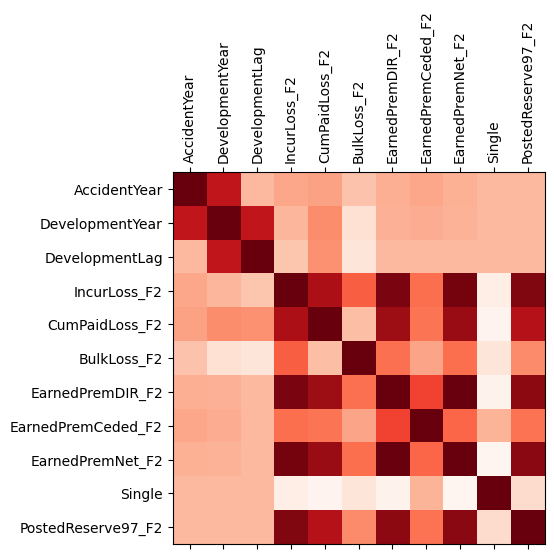

In [ ]:
matriz_correlaciones = df.select_dtypes(include=[np.number]).corr()
plt.matshow(matriz_correlaciones, cmap="Reds")
plt.xticks(np.arange(matriz_correlaciones.shape[0]), df.select_dtypes(include=[np.number]).columns, rotation=90)
plt.yticks(np.arange(matriz_correlaciones.shape[1]), df.select_dtypes(include=[np.number]).columns)
plt.show()

La matriz de correlaciones muestra una correlación muy alta entre las columnas IncurLoss_F2, CumPaidLoss_F2, BulkLoss_F2, EarnedPremDIR_F2, EarnedPremCeded_F2 y EarnedPremNet_F2. Esto sugiere que estas columnas están relacionadas entre sí y que pueden utilizarse para modelar las pérdidas.

La matriz de correlaciones es una herramienta útil para identificar relaciones entre variables. En este caso, la matriz muestra que las columnas relacionadas con las pérdidas están altamente correlacionadas entre sí. Esto sugiere que estas columnas pueden utilizarse para modelar las pérdidas de forma eficaz.

La comparación entre el monto total de las primas emitidas y los costos incurridos durante un período de 10 años hasta 1997 nos permitirá observar algunas compañías de seguros de malas prácticas médicas están perdiendo dinero. Esto se debe a que los costos de los siniestros, incluidos los pagos realizados y las reservas para siniestros reportados, superan el monto de las primas recibidas.

Esta comparación es importante porque permite identificar a las compañías que están teniendo problemas de rentabilidad. Los resultados nos muestraran algunas compañías pueden estar enfrentando dificultades para mantenerse en el mercado.

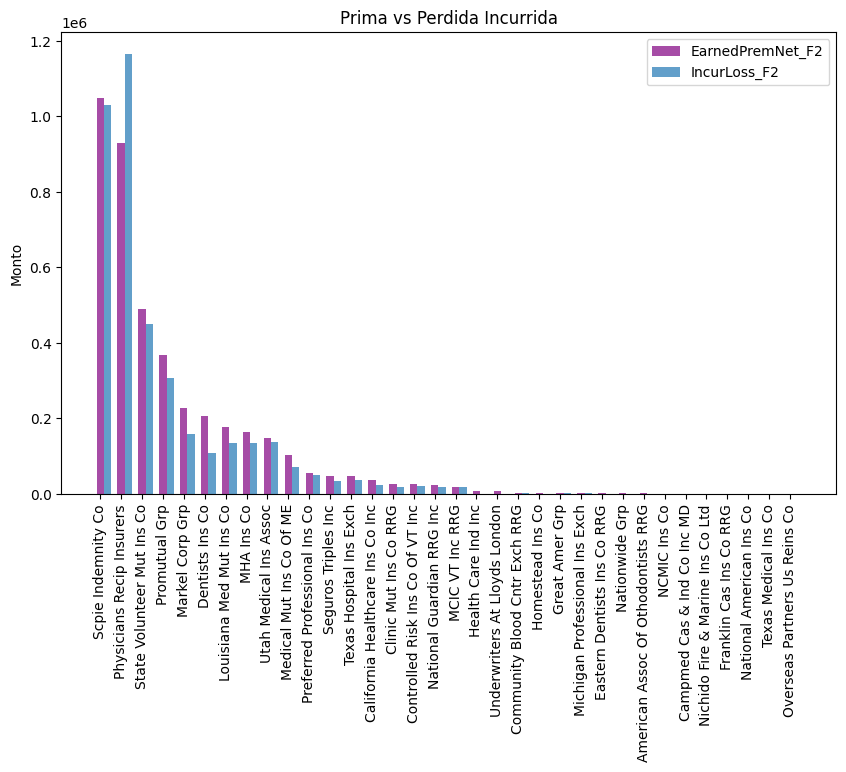

In [ ]:
df_triangulo = df[(df['DevelopmentYear']==1997)].copy()
df_triangulo = df_triangulo[['GRNAME', 'AccidentYear', 'DevelopmentYear', 'IncurLoss_F2','CumPaidLoss_F2', 'BulkLoss_F2', 'EarnedPremNet_F2']].copy()
grouped_data = df_triangulo.groupby('GRNAME').agg({'IncurLoss_F2': 'sum', 'EarnedPremNet_F2': 'sum'}).reset_index()
grouped_data_sorted = grouped_data.sort_values(by='EarnedPremNet_F2', ascending=False)
plt.figure(figsize=(10, 6))
num_groups = len(grouped_data_sorted['GRNAME'])
bar_width = 0.35
index_earned = range(num_groups)
index_incur = [i + bar_width for i in index_earned]
plt.bar(index_earned, grouped_data_sorted['EarnedPremNet_F2'], bar_width, label='EarnedPremNet_F2', alpha=0.7, color='purple')
plt.bar(index_incur, grouped_data_sorted['IncurLoss_F2'], bar_width, label='IncurLoss_F2', alpha=0.7)
plt.ylabel('Monto')
plt.title('Prima vs Perdida Incurrida')
plt.xticks(index_earned, grouped_data_sorted['GRNAME'], rotation='vertical')
plt.legend()
plt.show()

Dado nuestro argumento par ala generación de este gráfico, evidenciamos unicamente que para la corporación "Physicians Recip Insurers" es la única que presenta un mayor costo en incurridos que las primas recibidas. Esto sería una buena alerta para ellos dado que no les esta siendo rentable pero para las demás aunque no es muy significativo no están yendo a perdidas.

C:\Users\moshe\AppData\Local\Temp\ipykernel_25476\4032398861.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(data=primas, x='GRNAME', y='EarnedPremNet_F2', palette='Set1', order=order)


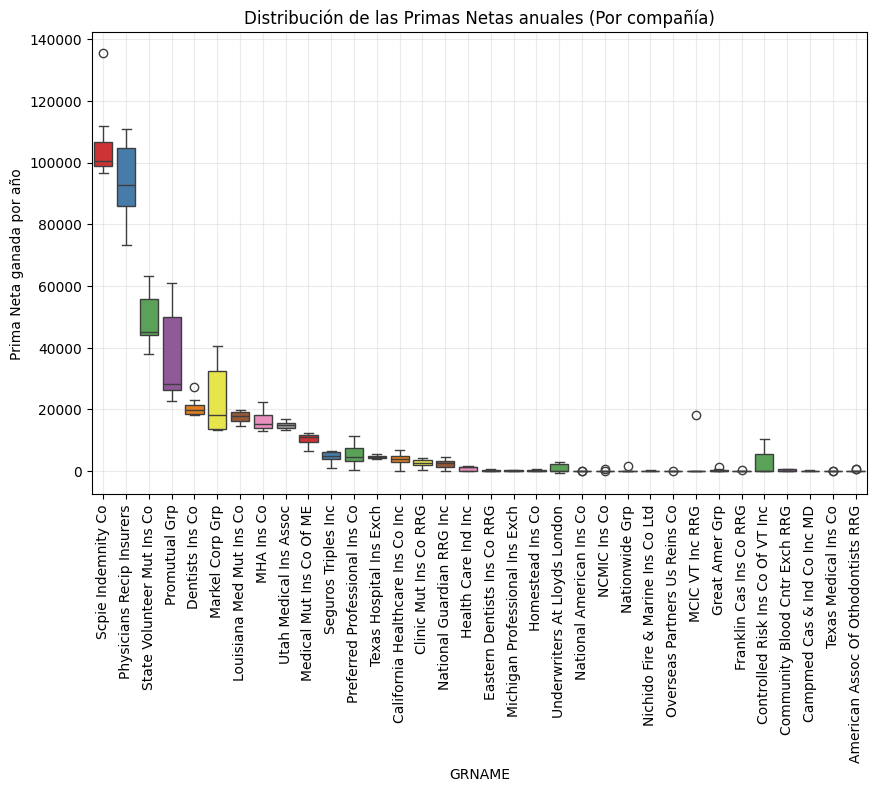

In [ ]:
primas = df[df.AccidentYear == df.DevelopmentYear].copy()
order = primas.groupby('GRNAME')['EarnedPremNet_F2'].median().sort_values(ascending=False).index
plt.figure(figsize=(10, 6))
plt.ylabel('Prima Neta ganada por año')
plt.title('Distribución de las Primas Netas anuales (Por compañía)')
plt.plot([1988, 1997], [primas['EarnedPremNet_F2'].mean(), primas['EarnedPremNet_F2'].mean()], lw=2, color='black')
boxplot = sns.boxplot(data=primas, x='GRNAME', y='EarnedPremNet_F2', palette='Set1', order=order)
plt.xticks(rotation=90)
plt.grid(which='both', axis='both', alpha=0.25)
plt.show()

El gráfico muestra la distribución de las primas netas anuales por compañía de seguros de malas prácticas médicas en los Estados Unidos, de 1988 a 1997. Las compañías se ordenan por mediana de primas netas, de mayor a menor.

El gráfico muestra que la distribución de las primas netas es muy heterogénea. Algunas compañías tienen primas netas muy altas, mientras que otras tienen primas netas muy bajas.

Las compañías con las primas netas más altas son:

Scpie Indemnity Co
Physicians Recip Insurers
State Volunteer Mut Ins Co
Promutuak Grp
Dentists Ins Co

Estas compañías son las principales aseguradoras de malas prácticas médicas en los Estados Unidos. Tienen una gran cuota de mercado y una amplia base de clientes.

Las compañías con las primas netas más bajas son:

- American Association of Othodontists RRG
- Texas Hospital Ins Exch
- Campmed Cas & Ind Co Inc MD
- Community Blood Cntr Exch PRG
- Controlled Risk Ins Co Of VT Inc

Estas compañías son más pequeñas y tienen una menor cuota de mercado.

El gráfico también muestra que, en general, las primas netas pueden haber aumentado a lo largo del tiempo. Esto se puede deberse a una serie de factores, como el aumento de los costos médicos, la creciente demanda de seguros de malas prácticas médicas y la expansión de las coberturas de los seguros.

Sin embargo, la distribución de las primas netas sigue siendo muy heterogénea. Esto sugiere que algunas compañías están teniendo más éxito que otras en la gestión de sus riesgos y en la obtención de primas de los clientes.

# Calidad de datos

La calidad de los datos es un aspecto fundamental para cualquier proyecto de análisis de datos. En el caso de los datos de malas prácticas médicas, la calidad es especialmente importante, ya que estos datos se utilizan para evaluar el desempeño de los profesionales de la salud y para tomar decisiones sobre la seguridad del paciente.

En el caso de los datos que se utilizarán para metodologías de modelado, es posible que no se encuentren datos incoherentes o vacíos. Esto se debe a que estos datos suelen ser limpios y estructurados, ya que han sido preparados para su uso en modelos de aprendizaje automático. Sin embargo, es importante realizar una revisión de la calidad de los datos, incluso en estos casos. Esto se debe a que pueden existir errores u omisiones que no sean inmediatamente evidentes.

La revisión de la calidad de los datos debe incluir los siguientes pasos:

Verificación de la integridad de los datos: Esto implica asegurarse de que los datos son completos y correctos.
Verificación de la consistencia de los datos: Esto implica asegurarse de que los datos están organizados de manera coherente y que los valores son consistentes entre sí.
Verificación de la relevancia de los datos: Esto implica asegurarse de que los datos son relevantes para el propósito del análisis.
La revisión de la calidad de los datos es una tarea importante que debe realizarse antes de comenzar cualquier análisis de datos. Esta tarea ayuda a garantizar que los resultados del análisis sean precisos y fiables.

In [ ]:
df.isnull().sum()+df.isna().sum()

GRCODE                0
GRNAME                0
AccidentYear          0
DevelopmentYear       0
DevelopmentLag        0
IncurLoss_F2          0
CumPaidLoss_F2        0
BulkLoss_F2           0
EarnedPremDIR_F2      0
EarnedPremCeded_F2    0
EarnedPremNet_F2      0
Single                0
PostedReserve97_F2    0
dtype: int64

Como era de esperarse no encontramos valores ausentes

In [ ]:
df["GRNAME"][df["IncurLoss_F2"] <= 0].unique()

array(['Great Amer Grp', 'Nationwide Grp',
       'Overseas Partners Us Reins Co', 'Eastern Dentists Ins Co RRG',
       'American Assoc Of Othodontists RRG',
       'Controlled Risk Ins Co Of VT Inc', 'Texas Medical Ins Co',
       'MCIC VT Inc RRG', 'Franklin Cas Ins Co RRG', 'Homestead Ins Co',
       'Campmed Cas & Ind Co Inc MD', 'Community Blood Cntr Exch RRG',
       'Underwriters At Lloyds London', 'NCMIC Ins Co',
       'National American Ins Co', 'Michigan Professional Ins Exch',
       'Nichido Fire & Marine Ins Co Ltd', 'Health Care Ind Inc',
       'National Guardian RRG Inc', 'California Healthcare Ins Co Inc'],
      dtype=object)

En este punto evidenciamos algunas compañias con valores negarivos sobre perdidas incurridas, se entrará en consideración si se eliminan o continuamos con estos. Esto se debe a que el valor negativo debe significar un valor para estas compañias y deseamos que el modelo sea robusto frente a estas situaciones.

# Método Chain Ladder

Empezaremos con el primer modelo tradicional y deterministico:

Pivoteamos la empresa que se extrajo en la celda anterior como Empresa1, esto para mostrar como queda un triangulo resuelto con valores reales

In [ ]:
Empresa1.pivot(index='AccidentYear', columns='DevelopmentLag', values='IncurLoss_F2')

DevelopmentLag,1,2,3,4,5,6,7,8,9,10
AccidentYear,,,,,,,,,,
1988,121905,112211,103226,99599,96006,90487,82640,80406,78920,78511
1989,122679,113165,110037,101142,90817,81919,77491,73577,72716,72317
1990,118157,117497,116377,99895,89252,81916,79134,76333,75612,75350
1991,117981,122443,121056,113795,102830,98071,94870,91062,90493,90345
1992,131059,130155,124195,113974,106817,99182,92588,91000,89256,89251
1993,134700,130757,125253,114717,111294,98014,96872,95714,96017,96047
1994,136749,128192,121355,111877,96152,91502,90498,91870,91848,91938
1995,140962,132405,118332,100050,88809,82360,81986,81887,81796,81782
1996,134473,128980,113645,104273,99276,97782,97282,97738,97601,97251


Veremos como llenamos los valores del triangulo inferior como ceros, posteriormente utilizaremos el objeto NaN

In [ ]:
Triangulo_acumulado = Empresa1.pivot(index='AccidentYear', columns='DevelopmentLag', values='IncurLoss_F2')
for i in range(len(Triangulo_acumulado)):
    for j in range(len(Triangulo_acumulado)):
        if j < i:
            Triangulo_acumulado[i+1].iloc[len(Triangulo_acumulado)-1-j] = 0
Triangulo_acumulado = Triangulo_acumulado.replace(0,np.nan)
Triangulo_acumulado

DevelopmentLag,1,2,3,4,5,6,7,8,9,10
AccidentYear,,,,,,,,,,
1988,121905,112211.0,103226.0,99599.0,96006.0,90487.0,82640.0,80406.0,78920.0,78511.0
1989,122679,113165.0,110037.0,101142.0,90817.0,81919.0,77491.0,73577.0,72716.0,NaN
1990,118157,117497.0,116377.0,99895.0,89252.0,81916.0,79134.0,76333.0,NaN,NaN
1991,117981,122443.0,121056.0,113795.0,102830.0,98071.0,94870.0,NaN,NaN,NaN
1992,131059,130155.0,124195.0,113974.0,106817.0,99182.0,NaN,NaN,NaN,NaN
1993,134700,130757.0,125253.0,114717.0,111294.0,NaN,NaN,NaN,NaN,NaN
1994,136749,128192.0,121355.0,111877.0,NaN,NaN,NaN,NaN,NaN,NaN
1995,140962,132405.0,118332.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,134473,128980.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Para este punto, teniendo el triangulo superior, procedemos con la completación del triangulo por medio del método Chain Ladder. Creamos un diccionario con algunos objetos de interés:

- Datos reales: Datos completos del triangulo
- Triangulo Acumulado: Presenta el triangulo superior, los demás valores NaN
- Links ratios: Presenta los pesos para cada una de las columnas
- CSA: Los pesos de expansión, estos permiten extrapolar la información para lograr estimar el triangulo inferior
- Triangulo Estimado: Presenta el triangulo completado, en la parte superior que viene siendo el histórico y el triangulo inferior la estimación bajo los ratios
- Reserva total: Es el valor total que debe retener o conseguir la empresa para lograr abarcar los posibles siniestros estimados

In [ ]:
import warnings
warnings.filterwarnings("ignore")
# Crea un pivote de datos para el triángulo de reservas
Triangulo_acumulado = Empresa1.pivot(index='AccidentYear', columns='DevelopmentLag', values='IncurLoss_F2')
for i in range(len(Triangulo_acumulado)):
    for j in range(len(Triangulo_acumulado)):
        if j < i:
            Triangulo_acumulado[i+1].iloc[len(Triangulo_acumulado)-1-j] = 0
Triangulo_acumulado = Triangulo_acumulado.replace(0,np.nan)
links_ratios = Triangulo_acumulado.applymap(lambda x: 0 if x != 0 else x)
links_ratios
for i in range(len(links_ratios)+1):
    for j in range(len(links_ratios)):
        if i > 1:
            links_ratios[i].iloc[j] = Triangulo_acumulado[i].iloc[j]/Triangulo_acumulado[i-1].iloc[j]
CSA = {}
for i in range(len(Triangulo_acumulado)-1):
    CSA[str(i+1)] = Triangulo_acumulado[i+1][0:len(Triangulo_acumulado[i+2].dropna())].sum()/Triangulo_acumulado[i+2].dropna().sum()
Triangulo_estimado = Triangulo_acumulado.copy()
for i in range(len(Triangulo_estimado)):
    for j in range(len(Triangulo_estimado)):
            if pd.isna(Triangulo_estimado[i+1].iloc[j]):
                Triangulo_estimado[i+1].iloc[j] = Triangulo_estimado[i].iloc[j]*CSA[str(i)]
Reserva_total = Reserva_total = (Triangulo_estimado[10] - list(np.diag(np.fliplr(Triangulo_estimado)))).sum()
consolidado = {'Datos_reales' : Empresa1.pivot(index='AccidentYear', columns='DevelopmentLag', values='IncurLoss_F2'),
                'Triangulo_acumulado': Triangulo_acumulado,
                'Links_ratios': links_ratios,
                'CSA': CSA,
                'Triangulo_estimado':Triangulo_estimado,
                'Reserva_total': Reserva_total}
consolidado['Triangulo_acumulado']

DevelopmentLag,1,2,3,4,5,6,7,8,9,10
AccidentYear,,,,,,,,,,
1988,121905,112211.0,103226.0,99599.0,96006.0,90487.0,82640.0,80406.0,78920.0,78511.0
1989,122679,113165.0,110037.0,101142.0,90817.0,81919.0,77491.0,73577.0,72716.0,NaN
1990,118157,117497.0,116377.0,99895.0,89252.0,81916.0,79134.0,76333.0,NaN,NaN
1991,117981,122443.0,121056.0,113795.0,102830.0,98071.0,94870.0,NaN,NaN,NaN
1992,131059,130155.0,124195.0,113974.0,106817.0,99182.0,NaN,NaN,NaN,NaN
1993,134700,130757.0,125253.0,114717.0,111294.0,NaN,NaN,NaN,NaN,NaN
1994,136749,128192.0,121355.0,111877.0,NaN,NaN,NaN,NaN,NaN,NaN
1995,140962,132405.0,118332.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,134473,128980.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Se genera una corrección para la seleccion de compañias, esto dado que algunas cuentan con ausencia de datos faltantes en el triangulo superior lo cual nos indica un inconveniente que para este documento no se abarcara. Por eso se omiten las compañias que cuentan con una presencia de al menos el 5% de datos nulos.

In [ ]:
empresas = df['GRNAME'].unique()
triangulos_empresas = {}
for empresa in empresas:
    Empresa1 = df[df['GRNAME']==empresa]
    Triangulo_acumulado = Empresa1.pivot(index='AccidentYear', columns='DevelopmentLag', values='IncurLoss_F2')
    if (np.count_nonzero(Triangulo_acumulado == 0)/Triangulo_acumulado.size*100) > 5:
        continue
    for i in range(len(Triangulo_acumulado)):
        for j in range(len(Triangulo_acumulado)):
            if j < i:
                Triangulo_acumulado[i+1].iloc[len(Triangulo_acumulado)-1-j] = 0
    Triangulo_acumulado = Triangulo_acumulado.replace(0,np.nan)
    links_ratios = Triangulo_acumulado.applymap(lambda x: 0 if x != 0 else x)
    links_ratios
    for i in range(len(links_ratios)+1):
        for j in range(len(links_ratios)):
            if i > 1:
                links_ratios[i].iloc[j] = Triangulo_acumulado[i].iloc[j]/Triangulo_acumulado[i-1].iloc[j]
    CSA = {}
    for i in range(len(Triangulo_acumulado)-1):
        CSA[str(i+1)] = Triangulo_acumulado[i+1][0:len(Triangulo_acumulado[i+2].dropna())].sum()/Triangulo_acumulado[i+2].dropna().sum()
    Triangulo_estimado = Triangulo_acumulado.copy()
    for i in range(len(Triangulo_estimado)):
        for j in range(len(Triangulo_estimado)):
                if pd.isna(Triangulo_estimado[i+1].iloc[j]):
                    Triangulo_estimado[i+1].iloc[j] = Triangulo_estimado[i].iloc[j]*CSA[str(i)]
    Reserva_total = Reserva_total = (Triangulo_estimado[10] - list(np.diag(np.fliplr(Triangulo_estimado)))).sum()
    consolidado = {'Datos_reales' : Empresa1.pivot(index='AccidentYear', columns='DevelopmentLag', values='IncurLoss_F2'),
                    'Triangulo_acumulado': Triangulo_acumulado,
                    'Links_ratios': links_ratios,
                    'CSA': CSA,
                    'Triangulo_estimado':Triangulo_estimado,
                    'Reserva_total': Reserva_total}
    triangulos_empresas[empresa] = consolidado

Solucionado los problemas hasta el momento presenciados bajo el método Chain Ladder, procedemos con la creación de una función lo cual no ayudara a optimizar y ser más eficientes a la hora de calcular los triángulos estimados para todas las categorías. Para este caso, la función se llamara triángulos, el input será la data en bruto y retornara el diccionario calculado anteriormente para cada una claves de este que vendrán siendo los nombres de cada una de las compañías que cuentan con los criterios para ser analizadas.

In [ ]:
def triangulos(data):
    empresas = df['GRNAME'].unique()
    triangulos_empresas = {}
    for empresa in empresas:
        Empresa1 = df[df['GRNAME']==empresa]
        Triangulo_acumulado = Empresa1.pivot(index='AccidentYear', columns='DevelopmentLag', values='IncurLoss_F2')
        if (np.count_nonzero(Triangulo_acumulado == 0)/Triangulo_acumulado.size*100) > 1:
            continue
        for i in range(len(Triangulo_acumulado)):
            for j in range(len(Triangulo_acumulado)):
                if j < i:
                    Triangulo_acumulado[i+1].iloc[len(Triangulo_acumulado)-1-j] = 0
        Triangulo_acumulado = Triangulo_acumulado.replace(0,np.nan)
        links_ratios = Triangulo_acumulado.applymap(lambda x: 0 if x != 0 else x)
        links_ratios
        for i in range(len(links_ratios)+1):
            for j in range(len(links_ratios)):
                if i > 1:
                    links_ratios[i].iloc[j] = Triangulo_acumulado[i].iloc[j]/Triangulo_acumulado[i-1].iloc[j]
        CSA = {}
        for i in range(len(Triangulo_acumulado)-1):
            CSA[str(i+1)] = Triangulo_acumulado[i+1][0:len(Triangulo_acumulado[i+2].dropna())].sum()/Triangulo_acumulado[i+2].dropna().sum()
        Triangulo_estimado = Triangulo_acumulado.copy()
        for i in range(len(Triangulo_estimado)):
            for j in range(len(Triangulo_estimado)):
                    if pd.isna(Triangulo_estimado[i+1].iloc[j]):
                        Triangulo_estimado[i+1].iloc[j] = Triangulo_estimado[i].iloc[j]*CSA[str(i)]
        Reserva_total = (Triangulo_estimado[10] - list(np.diag(np.fliplr(Triangulo_estimado)))).sum()
        consolidado = {'Datos_reales' : Empresa1.pivot(index='AccidentYear', columns='DevelopmentLag', values='IncurLoss_F2'),
                       'Triangulo_acumulado': Triangulo_acumulado,
                       'Links_ratios': links_ratios,
                       'CSA': CSA,
                       'Triangulo_estimado':Triangulo_estimado,
                       'Reserva_reclamos': Reserva_total}
        triangulos_empresas[empresa] = consolidado
    return triangulos_empresas

Ejecutamos la función y la asignamos a 'triangulos_empresas', luego validaremos la respectivas llaves para acceder a cada uno de los objetos creados para cada empresa

In [ ]:
triangulos_empresas = triangulos(df)

In [ ]:
triangulos_empresas['Scpie Indemnity Co']['Triangulo_acumulado']

DevelopmentLag,1,2,3,4,5,6,7,8,9,10
AccidentYear,,,,,,,,,,
1988,121905,112211.0,103226.0,99599.0,96006.0,90487.0,82640.0,80406.0,78920.0,78511.0
1989,122679,113165.0,110037.0,101142.0,90817.0,81919.0,77491.0,73577.0,72716.0,NaN
1990,118157,117497.0,116377.0,99895.0,89252.0,81916.0,79134.0,76333.0,NaN,NaN
1991,117981,122443.0,121056.0,113795.0,102830.0,98071.0,94870.0,NaN,NaN,NaN
1992,131059,130155.0,124195.0,113974.0,106817.0,99182.0,NaN,NaN,NaN,NaN
1993,134700,130757.0,125253.0,114717.0,111294.0,NaN,NaN,NaN,NaN,NaN
1994,136749,128192.0,121355.0,111877.0,NaN,NaN,NaN,NaN,NaN,NaN
1995,140962,132405.0,118332.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,134473,128980.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Para este punto presenciamos la realización de estimaciones para cada una de las empresas que estamos considerando, necesitamos comparar los resultados con otro método. Procederemos con la estimación bajo regresión.

In [ ]:
MAPE1 = []
for i in list(triangulos_empresas.keys()):
    diferencia = abs((triangulos_empresas[i]["Datos_reales"]-triangulos_empresas[i]["Triangulo_estimado"])/triangulos_empresas[i]["Datos_reales"])
    MAPE = diferencia.sum().sum()/45*100
    MAPE1.append(MAPE)
MAPE1 = np.array(MAPE1)
Mape_chain_ladder = MAPE1.mean()
print("Métrica MAPE con el método Chain-Ladder:", Mape_chain_ladder)

Métrica MAPE con el método Chain-Ladder: 51.44492321441913


# Método de Regresión

Tomaremos los datos incluyendo los NaN y los convertimos en un vector, esto nos permitirá poder trabajar con las 'n' compañias lo cual intentaremos abarcar en su totalidad todas las compañias a la misma vez para evitar perder algún tipo de información

In [ ]:
triangulos_empresas['Scpie Indemnity Co']['Triangulo_acumulado'].values.flatten()

array([121905., 112211., 103226.,  99599.,  96006.,  90487.,  82640.,
        80406.,  78920.,  78511., 122679., 113165., 110037., 101142.,
        90817.,  81919.,  77491.,  73577.,  72716.,     nan, 118157.,
       117497., 116377.,  99895.,  89252.,  81916.,  79134.,  76333.,
           nan,     nan, 117981., 122443., 121056., 113795., 102830.,
        98071.,  94870.,     nan,     nan,     nan, 131059., 130155.,
       124195., 113974., 106817.,  99182.,     nan,     nan,     nan,
           nan, 134700., 130757., 125253., 114717., 111294.,     nan,
           nan,     nan,     nan,     nan, 136749., 128192., 121355.,
       111877.,     nan,     nan,     nan,     nan,     nan,     nan,
       140962., 132405., 118332.,     nan,     nan,     nan,     nan,
           nan,     nan,     nan, 134473., 128980.,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan, 137944.,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     

Generaremos a partir de los triángulos retornados por la función 'triángulos', esto dado que contaremos con los triángulos que cuentan con la totalidad de los datos que permitirá validar las estimaciones. Creamos una lista y será poblada con la cantidad de empresas que han sido seleccionadas

In [ ]:
keys = list(triangulos_empresas.keys())
y = []
for k in keys:
    y = np.concatenate((y, triangulos_empresas[k]['Triangulo_acumulado'].values.flatten()))
y.shape

(1400,)

Dado que el método por regresión tiene un supuesto de que la variable respuesta es el logaritmo de y, procedemos a obtenerla

In [ ]:
y_log = [math.log(x) for x in y]

Para este punto sacaremos la matriz donde se encontraran los indicadores de la presencia de algún parametro, esto nos indica que para la genración de la observación m se produce por el cruce del año k y el lag l.
Primeramente creamos una matriz con las respetivas dimensiones obtenidas de la función 'triangulos', esta contará con unicamente valores de cero para luego ser poblada por un loop

In [ ]:
x = np.zeros((triangulos_empresas[list(triangulos_empresas.keys())[0]]['Triangulo_acumulado'].shape[0]*triangulos_empresas[list(triangulos_empresas.keys())[0]]['Triangulo_acumulado'].shape[1],
              sum(triangulos_empresas[list(triangulos_empresas.keys())[0]]['Triangulo_acumulado'].shape)-2+1))
x.shape

(100, 19)

Acá se procede con el poblamiento de las indicadoras de los parámetros que generan cada una de las observaciones, recordar que para el año y el lag 1, los valores de estos parámetros son cero

In [ ]:
l = triangulos_empresas[list(triangulos_empresas.keys())[0]]['Triangulo_acumulado'].shape[0]
for i in range(x.shape[0]):
    x[i, 0] = 1
    x[i,i%l] = 1
    if i >= 10:
          entero = int(i/10)
          x[i,l+entero-1] = 1
X = x
for i in range(len(list(triangulos_empresas.keys()))-1):
     X = np.vstack((X, x))

Validamos dimensiones dado que más adelante procederemos con multiplicación de estos

In [ ]:
x.shape, X.shape, len(y_log)

((100, 19), (1400, 19), 1400)

Redimensionamos el vector y para concatenar con la matriz X

In [ ]:
np.array(y_log).reshape(1, 1400).T.shape

(1400, 1)

Concatenamos las dos matrices, la matriz de indicadoras de parametros y de la variable respuesta que en este caso es log(y)

In [ ]:
XY_log = np.concatenate([X, np.array(y_log).reshape(1, 1400).T], axis=1)
XY_log.shape

(1400, 20)

Una vez validadas las dimensiones de los objetos y la concatenación de los mismos, procedemos con la eliminación de valores NaN para unicamente trabajar los los valores que se cuentan. Los valores que eliminamos 'NaN' se utilizaran más adelante para testear los resultados

In [ ]:
df_XY_log = pd.DataFrame(XY_log)
df_XY_log = df_XY_log.dropna()
df_XY_log.shape

(770, 20)

Concatenamos las dos matrices dado que 'y' era la que contaba con los NaN, una vez borradas las filas que tiene ausencia de datos procedemos otra vez a tener por separado cada una de las matrices para poder multiplicarlas más adelante

In [ ]:
x_omitnan = df_XY_log.iloc[:, :-1]
y_log_omitnan = df_XY_log.iloc[:,-1]
x_omitnan.shape,y_log_omitnan.shape

((770, 19), (770,))

Encontramos para este punto el vector de betas estimados por medio del método de mínimos cuadrados

In [ ]:
b_est = np.dot(np.dot(np.linalg.inv(np.dot(x_omitnan.T,x_omitnan)),x_omitnan.T),y_log_omitnan)
exp_b_est = np.exp(b_est)
b_est.shape

(19,)

Para este punto recordamos que nuestra variable respuesta 'y' realmente es 'log(y)' por lo que extraemos exponencial de estas estimaciones

In [ ]:
est = np.dot(x_omitnan,b_est)
exp_est = np.dot(x_omitnan,exp_b_est)

Seleccionamos una métrica de testeo

In [ ]:
MAPE = 100 * np.mean(np.abs((y_log_omitnan - est) / y_log_omitnan))
MAPE


11.836502725409046

Para este punto hallamos el IBNR

In [ ]:
IBNR = sum(exp_est)
IBNR

6968480.673041882

Procedemos con algunas validaciones de los parámetros obtenidos manualmente y utilizando la librería 'Sklearn'. Hacemos esto dado que sabemos que la multiplicación de matrices demanda bastantes recursos y queremos escalarlo a muchas empresas

Utilizando la librería

In [ ]:
modelo = LinearRegression()
modelo.fit(X = x_omitnan, y = y_log_omitnan)
modelo.coef_.flatten(),modelo.intercept_

(array([ 0.        , -0.05366319, -0.12604845, -0.22685027, -0.28797468,
        -0.35457203, -0.39991772, -0.49217904, -0.49546519, -0.51181813,
         0.29862739,  0.39832096,  0.53248843,  0.60872173,  0.63867745,
         0.75294324,  0.81777038,  0.84446757,  0.69437918]),
 9.110288379706647)

Estimaciones obtenidas manualmente por mínimos cuadrados

In [ ]:
b_est

array([ 9.11028838, -0.05366319, -0.12604845, -0.22685027, -0.28797468,
       -0.35457203, -0.39991772, -0.49217904, -0.49546519, -0.51181813,
        0.29862739,  0.39832096,  0.53248843,  0.60872173,  0.63867745,
        0.75294324,  0.81777038,  0.84446757,  0.69437918])

Creamos una función que recoge todos los pasos anteriores y los consolida en un solo objeto, esto permitirá replicarlo con cualquier base de datos que tenga la misma estructura de columnas cabe resaltar

Se comentan la parte de mínimos cuadrados dado que esto demanda bastantes recursos, utilizamos la función sklearn que esta optimizada para la obtención de parámetros, de igual forma los valores de las métricas dado que más adelante se utilizara esta función en unas funciones más completas, se dejan comentadas para que se pueda replicar y que solo necesiten comparar unicamente 3 modelos

In [ ]:
def regresion(triangulos_empresas):
    keys = list(triangulos_empresas.keys())
    y = []
    for k in keys:
        y = np.concatenate((y, triangulos_empresas[k]['Triangulo_acumulado'].values.flatten()))
    y_log = [math.log(x) for x in y]
    x = np.zeros((triangulos_empresas[list(triangulos_empresas.keys())[0]]['Triangulo_acumulado'].shape[0]*triangulos_empresas[list(triangulos_empresas.keys())[0]]['Triangulo_acumulado'].shape[1],
                  sum(triangulos_empresas[list(triangulos_empresas.keys())[0]]['Triangulo_acumulado'].shape)-2+1))
    l = triangulos_empresas[list(triangulos_empresas.keys())[0]]['Triangulo_acumulado'].shape[0]
    for i in range(x.shape[0]):
        x[i, 0] = 1
        x[i,i%l] = 1
        if i >= 10:
            entero = int(i/10)
            x[i,l+entero-1] = 1
    X = x
    for i in range(len(list(triangulos_empresas.keys()))-1):
        X = np.vstack((X, x))
    XY_log = np.concatenate([X, np.array(y_log).reshape(1, 1400).T], axis=1)
    df_XY_log = pd.DataFrame(XY_log)
    df_XY_log = df_XY_log.dropna()
    x_omitnan = df_XY_log.iloc[:, :-1]
    y_log_omitnan = df_XY_log.iloc[:,-1]

    ##regresion lineal
    #b_est = np.dot(np.dot(np.linalg.inv(np.dot(x_omitnan.T,x_omitnan)),x_omitnan.T),y_log_omitnan)
    #exp_b_est = np.exp(b_est)
    #exp_est = np.dot(x_omitnan,exp_b_est)
    #est = np.dot(x_omitnan,b_est)
    modelo_lineal = LinearRegression()
    modelo_lineal.fit(X = x_omitnan, y = y_log_omitnan)
    b_est_lineal = modelo_lineal.coef_
    b_est_lineal[0] = modelo_lineal.intercept_
    est_lineal = np.dot(x_omitnan,b_est_lineal)
    #MAPE_lineal = 100 * np.mean(np.abs((y_log_omitnan - est_lineal) / y_log_omitnan))

    ##regresion Ridge
    modelo_ridge = Ridge()
    modelo_ridge.fit(X = x_omitnan, y = y_log_omitnan)
    b_est_ridge = modelo_ridge.coef_
    b_est_ridge[0] = modelo_ridge.intercept_
    est_ridge = np.dot(x_omitnan,b_est_ridge)
    #MAPE_ridge = 100 * np.mean(np.abs((y_log_omitnan - est_ridge) / y_log_omitnan))

    ##regresion Lasso
    modelo_lasso = Lasso()
    modelo_lasso.fit(X = x_omitnan, y = y_log_omitnan)
    b_est_lasso = modelo_lasso.coef_
    b_est_lasso[0] = modelo_lasso.intercept_
    est_lasso = np.dot(x_omitnan,b_est_lasso)
    #MAPE_lasso = 100 * np.mean(np.abs((y_log_omitnan - est_lasso) / y_log_omitnan))
    #
    #MAPE = {'b_est_lineal':MAPE_lineal,'b_est_ridge':MAPE_ridge,'b_est_lasso':MAPE_lasso}
    #modelo_optimo = locals()[min(MAPE, key=MAPE.get)]
    modelo_optimo = [b_est_lineal,b_est_ridge,b_est_lasso,x_omitnan.index]
    return modelo_optimo

Como se comento anteriormente, se desea que la función se logre replicar sin importar la base de datos que se le suministra. Se hacen algunos cambios que permitan esto

In [ ]:
x = np.zeros((triangulos_empresas[list(triangulos_empresas.keys())[0]]['Triangulo_acumulado'].shape[0]*triangulos_empresas[list(triangulos_empresas.keys())[0]]['Triangulo_acumulado'].shape[1],
                sum(triangulos_empresas[list(triangulos_empresas.keys())[0]]['Triangulo_acumulado'].shape)-2+1))
l = triangulos_empresas[list(triangulos_empresas.keys())[0]]['Triangulo_acumulado'].shape[0]
for i in range(x.shape[0]):
    x[i, 0] = 1
    x[i,i%l] = 1
    if i >= 10:
        entero = int(i/10)
        x[i,l+entero-1] = 1
X = x
for i in range(len(list(triangulos_empresas.keys()))-1):
    X = np.vstack((X, x))

def regresion(triangulos_empresas,X):
    keys = list(triangulos_empresas.keys())
    y = []
    for k in keys:
        y = np.concatenate((y, triangulos_empresas[k]['Triangulo_acumulado'].values.flatten()))
    y_log = [math.log(x) for x in y]
    XY_log = np.concatenate([X, np.array(y_log).reshape(1, X.shape[0]).T], axis=1)
    df_XY_log = pd.DataFrame(XY_log)
    df_XY_log = df_XY_log.dropna()
    x_omitnan = df_XY_log.iloc[:, :-1]
    y_log_omitnan = df_XY_log.iloc[:,-1]

    ##regresion lineal
    modelo_lineal = LinearRegression()
    modelo_lineal.fit(X = x_omitnan, y = y_log_omitnan)
    b_est_lineal = modelo_lineal.coef_
    b_est_lineal[0] = modelo_lineal.intercept_
    est_lineal = np.dot(x_omitnan,b_est_lineal)

    ##regresion Ridge
    modelo_ridge = Ridge()
    modelo_ridge.fit(X = x_omitnan, y = y_log_omitnan)
    b_est_ridge = modelo_ridge.coef_
    b_est_ridge[0] = modelo_ridge.intercept_
    est_ridge = np.dot(x_omitnan,b_est_ridge)

    ##regresion Lasso
    modelo_lasso = Lasso()
    modelo_lasso.fit(X = x_omitnan, y = y_log_omitnan)
    b_est_lasso = modelo_lasso.coef_
    b_est_lasso[0] = modelo_lasso.intercept_
    est_lasso = np.dot(x_omitnan,b_est_lasso)

    modelo_optimo = [b_est_lineal,b_est_ridge,b_est_lasso,x_omitnan.index]
    return modelo_optimo

Ya teniendo la generalización de la función de regresión, se procede con la cración de validación. Se itera una de las empresas para testear bajo el triangulo inferior con las estimaciones de los tres modelos de regresión generados con las demás empresas no seleccionadas; nos retorna una lista con los mejores modelos seleccionados en cada iteración de empresa anclada

In [ ]:
def validacion(triangulos_empresas):
    triangulos = list(triangulos_empresas.keys())
    x = np.zeros((triangulos_empresas[list(triangulos_empresas.keys())[0]]['Triangulo_acumulado'].shape[0]*triangulos_empresas[list(triangulos_empresas.keys())[0]]['Triangulo_acumulado'].shape[1],
                    sum(triangulos_empresas[list(triangulos_empresas.keys())[0]]['Triangulo_acumulado'].shape)-2+1))
    l = triangulos_empresas[list(triangulos_empresas.keys())[0]]['Triangulo_acumulado'].shape[0]
    for i in range(x.shape[0]):
        x[i, 0] = 1
        x[i,i%l] = 1
        if i >= 10:
            entero = int(i/10)
            x[i,l+entero-1] = 1
    X = x
    for i in range(len(list(triangulos_empresas.keys()))-2):
        X = np.vstack((X, x))
    for i in range(len(list(triangulos_empresas.keys()))-1):
        X_0 = np.vstack((X, x))
    regresion0 = regresion(triangulos_empresas,X_0)

    best_i = []
    for i in triangulos:
        print(i)
        triangulos_empresas_i = triangulos_empresas.copy()
        del triangulos_empresas_i[i]
        y = triangulos_empresas[i]['Datos_reales'].values.flatten()
        y_log = [math.log(x) for x in y]
        XY_log = np.concatenate([x, np.array(y_log).reshape(1, 100).T], axis=1)
        XY_log = pd.DataFrame(XY_log).drop(regresion0[3][regresion0[3]<100])
        x_test = XY_log.iloc[:, :-1]
        y_test = XY_log.iloc[:, -1]
        regresion_i = regresion(triangulos_empresas_i,X)
        est_lineal = np.dot(x_test,regresion_i[0])
        est_ridge = np.dot(x_test,regresion_i[1])
        est_lasso = np.dot(x_test,regresion_i[2])

        MAPE_lineal = 100 * np.mean(np.abs((y_test - est_lineal) / y_test))
        MAPE_ridge = 100 * np.mean(np.abs((y_test - est_ridge) / y_test))
        MAPE_lasso = 100 * np.mean(np.abs((y_test - est_lasso) / y_test))
        MAPE = {'est_lineal':MAPE_lineal,'est_ridge':MAPE_ridge,'est_lasso':MAPE_lasso}
        modelo_optimo = locals()[min(MAPE, key=MAPE.get)]
        best_i.append(modelo_optimo)

    return best_i



In [ ]:
x = validacion(triangulos_empresas)

Scpie Indemnity Co
Promutual Grp
Markel Corp Grp
Texas Hospital Ins Exch
State Volunteer Mut Ins Co


MHA Ins Co
Preferred Professional Ins Co
Medical Mut Ins Co Of ME
Utah Medical Ins Assoc
Seguros Triples Inc
Dentists Ins Co
Physicians Recip Insurers
Louisiana Med Mut Ins Co
Clinic Mut Ins Co RRG


Con el fin de construir un modelo más robusto generamos la función 'cross_validation', para este caso iteramos anclando una empresa para el test; con las otras faltantes se procede metodología utilizada en la función de 'validacion' construida y comentada anteriormente. Recordar que el test se hace con la empresa que estamos iterando en primera instancia y se hace con el triangulo inferior. Esta función nos retornará un vector de 'n' mejores modelo que estiman las 'n' empresas y de igual manera el mejor modelo generado para todas las posibles iteraciones realizadas

In [ ]:
def cross_validation(triangulos_empresas):
    triangulos = list(triangulos_empresas.keys())
    x = np.zeros((triangulos_empresas[list(triangulos_empresas.keys())[0]]['Triangulo_acumulado'].shape[0]*triangulos_empresas[list(triangulos_empresas.keys())[0]]['Triangulo_acumulado'].shape[1],
                    sum(triangulos_empresas[list(triangulos_empresas.keys())[0]]['Triangulo_acumulado'].shape)-2+1))
    l = triangulos_empresas[list(triangulos_empresas.keys())[0]]['Triangulo_acumulado'].shape[0]
    for i in range(x.shape[0]):
        x[i, 0] = 1
        x[i,i%l] = 1
        if i >= 10:
            entero = int(i/10)
            x[i,l+entero-1] = 1
    X = x
    for i in range(len(list(triangulos_empresas.keys()))-3):
        X = np.vstack((X, x))
    X_0 = x
    for i in range(len(list(triangulos_empresas.keys()))-1):
        X_0 = np.vstack((X_0, x))
    regresion0 = regresion(triangulos_empresas,X_0)

    best = []
    int_j = 0
    for j in triangulos:
        int_j += 1
        print(f"Test {int_j}: Tomando como Test el triangulo de la empresa {j}")
        best_i = []
        triangulos_empresas_j = triangulos_empresas.copy()
        del triangulos_empresas_j[j]
        triangulos_j = list(triangulos_empresas_j.keys())
        int_i = 0
        for i in triangulos_j:
            int_i += 1
            print(f"Validación {int_i}: Tomando como validador el triangulo de la empresa {i}")
            triangulos_empresas_i = triangulos_empresas_j.copy()
            del triangulos_empresas_i[i]
            y = triangulos_empresas[i]['Datos_reales'].values.flatten()
            y_log = [math.log(x) for x in y]
            XY_log = np.concatenate([x, np.array(y_log).reshape(1, 100).T], axis=1)
            XY_log = pd.DataFrame(XY_log).drop(regresion0[3][regresion0[3]<100])
            x_test = XY_log.iloc[:, :-1]
            y_test = XY_log.iloc[:, -1]
            regresion_i = regresion(triangulos_empresas_i,X)
            lineal = regresion_i[0]
            ridge = regresion_i[1]
            lasso = regresion_i[2]
            est_lineal = np.dot(x_test,lineal)
            est_ridge = np.dot(x_test,ridge)
            est_lasso = np.dot(x_test,lasso)

            MAPE_lineal = 100 * np.mean(np.abs((y_test - est_lineal) / y_test))
            MAPE_ridge = 100 * np.mean(np.abs((y_test - est_ridge) / y_test))
            MAPE_lasso = 100 * np.mean(np.abs((y_test - est_lasso) / y_test))
            MAPE = {'lineal':MAPE_lineal,'ridge':MAPE_ridge,'lasso':MAPE_lasso}
            modelo_optimo = locals()[min(MAPE, key=MAPE.get)]
            best_i.append(modelo_optimo)
        y = triangulos_empresas[j]['Datos_reales'].values.flatten()
        y_log = [math.log(x) for x in y]
        XY_log = np.concatenate([x, np.array(y_log).reshape(1, 100).T], axis=1)
        XY_log = pd.DataFrame(XY_log).drop(regresion0[3][regresion0[3]<100])
        x_test = XY_log.iloc[:, :-1]
        y_test = XY_log.iloc[:, -1]
        best_model = best_i[0]

        for k in range(len(best_i)):
            est_modelo =  np.dot(x_test,best_i[k])
            mape = np.mean(np.abs((y_test - est_modelo) / y_test))
            if mape < np.mean(np.abs((y_test - np.dot(x_test,best_model) / y_test))):
                best_model = best_i[k]
        best.append(best_model)
    best_model = best[0]
    for m in range(len(best)):
            est_modelo =  np.dot(x_test,best[m])
            mape = np.mean(np.abs((y_test - est_modelo) / y_test))
            if mape < np.mean(np.abs((y_test - np.dot(x_test,best_model) / y_test))):
                best_model = best[m]
                best_mape = np.mean(np.abs((y_test - np.dot(x_test,best_model) / y_test)))

    return {"best_model":best_model,"best_mape":best_mape,"best":best}

Corremos la función para obtención de los mejores modelos para las 'n' corridas y el mejor modelo en general

In [ ]:
x = cross_validation(triangulos_empresas)

Test 1: Tomando como Test el triangulo de la empresa Scpie Indemnity Co
Validación 1: Tomando como validador el triangulo de la empresa Promutual Grp
Validación 2: Tomando como validador el triangulo de la empresa Markel Corp Grp
Validación 3: Tomando como validador el triangulo de la empresa Texas Hospital Ins Exch
Validación 4: Tomando como validador el triangulo de la empresa State Volunteer Mut Ins Co
Validación 5: Tomando como validador el triangulo de la empresa MHA Ins Co


Validación 6: Tomando como validador el triangulo de la empresa Preferred Professional Ins Co
Validación 7: Tomando como validador el triangulo de la empresa Medical Mut Ins Co Of ME
Validación 8: Tomando como validador el triangulo de la empresa Utah Medical Ins Assoc
Validación 9: Tomando como validador el triangulo de la empresa Seguros Triples Inc
Validación 10: Tomando como validador el triangulo de la empresa Dentists Ins Co
Validación 11: Tomando como validador el triangulo de la empresa Physicians Recip Insurers
Validación 12: Tomando como validador el triangulo de la empresa Louisiana Med Mut Ins Co
Validación 13: Tomando como validador el triangulo de la empresa Clinic Mut Ins Co RRG
Test 2: Tomando como Test el triangulo de la empresa Promutual Grp
Validación 1: Tomando como validador el triangulo de la empresa Scpie Indemnity Co
Validación 2: Tomando como validador el triangulo de la empresa Markel Corp Grp
Validación 3: Tomando como validador el triangulo de la empresa Tex

Obtención del mejor modelo

In [ ]:
x['best_model']

array([ 9.2965389 , -0.03375131, -0.10635558, -0.19347711, -0.27043903,
       -0.34656791, -0.39947064, -0.4970425 , -0.51208459, -0.54524698,
        0.27208802,  0.39185737,  0.46231309,  0.54206175,  0.55286739,
        0.66352384,  0.74024705,  0.7818943 ,  0.70097541])

In [ ]:
x['best_mape']

6.070558123909585